# Part C: Decision Tree Implementation

In [25]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from collections import Counter
import random

data = load_breast_cancer()
X, y = data.data, data.target

print(data)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train set size: {len(X_train)} samples (70%)")
print(f"Validation set size: {len(X_val)} samples (15%)")
print(f"Test set size: {len(X_test)} samples (15%)")

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
 

## Entropy and Information Gain
We use Entropy to measure the impurity. For a set of samples $S$ with classes $C$, the entropy is defined as:$$H(S) = - \sum_{c \in C} p(c) \log_2 p(c)$$Where $p(c)$ is the proportion of samples belonging to class $c$.To decide the best split, we calculate the Information Gain (IG). If we split a parent node $S$ into a left child $S_L$ and a right child $S_R$ using a feature threshold, the gain is:$$IG = H(S) - \left( \frac{|S_L|}{|S|} H(S_L) + \frac{|S_R|}{|S|} H(S_R) \right)$$We seek to maximize this value at every split.

In [26]:
def entropy(y):
    if len(y) == 0:
        return 0
    # Count each class
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    # Entropy formula: -summation(p * log2(p))
    entropy_value = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy_value

def information_gain(y_parent, y_left, y_right):
    p = len(y_left) / len(y_parent)
    # IG = H(parent) - [weighted average of children's entropy]
    return entropy(y_parent) - (p * entropy(y_left) + (1 - p) * entropy(y_right))

def majority_vote(y):
    # Find the most common element in y
    return Counter(y).most_common(1)[0][0]

In [27]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

        # Leaf Node attribute (used for prediction)
        self.value = value

    # Check if this node is a leaf
    def is_leaf(self):
        return self.value is not None

## Decision Tree Classifier Class

Stopping Criteria: Max depth (max_depth), minimum samples (min_samples_split), or pure nodes.

Max Features Compatibility: It includes max_features logic. For this part, we will use max_features=None (using all features). For the Random Forest, we can switch this to sqrt.

In [28]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features 
        self.root = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Determine features to consider at each split
        if self.max_features is None:
            self.feature_indices = np.arange(n_features) # All features
        elif isinstance(self.max_features, int):
            self.feature_indices = np.arange(n_features) # Will subsample later
        elif isinstance(self.max_features, float):
             # uses ratio for max features
            self.feature_indices = np.arange(n_features)
        else:
             self.feature_indices = np.arange(n_features)


        self.root = self._grow_tree(X, y, 0)
        return self

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        # 1-Reached max depth
        # 2-Samples less than minimum samples to split
        # 3-Pure node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = majority_vote(y)
            return Node(value=leaf_value)

        # Find best split
        # If max_features is set we select a random subset of features
        if self.max_features is None:
            feat_indices = self.feature_indices # Use all features
        else:
            # Randomly sample features for this split
            k = int(self.max_features) if isinstance(self.max_features, int) else int(np.sqrt(n_features))
            feat_indices = random.sample(list(self.feature_indices), k)
        
        best_feat, best_thresh = self._best_split(X, y, feat_indices)

        # If no gain found then this is a leaf node
        if best_feat is None:
            return Node(value=majority_vote(y))

        # --- Split Data ---
        left_indices = X[:, best_feat] <= best_thresh
        right_indices = X[:, best_feat] > best_thresh

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # --- Recursive Call ---
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        return Node(best_feat, best_thresh, left_child, right_child)


    def _best_split(self, X, y, feature_indices):
        max_gain = -1
        best_feat, best_thresh = None, None

        for feat_idx in feature_indices:
            # Use sorted distinct values as candidate thresholds
            thresholds = np.unique(X[:, feat_idx])

            for thresh in thresholds:
                # Split on the threshold: x_j <= t and x_j > t
                left_indices = X[:, feat_idx] <= thresh
                right_indices = X[:, feat_idx] > thresh

                y_left, y_right = y[left_indices], y[right_indices]

                # Ensure split is valid (not empty on one side)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Compute Information Gain
                current_gain = information_gain(y, y_left, y_right)

                # Update best split if gain is higher
                if current_gain > max_gain:
                    max_gain = current_gain
                    best_feat = feat_idx
                    best_thresh = thresh

        return best_feat, best_thresh

    def predict(self, X):
        #Returns predictions for a list of samples
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        # Check the condition at the internal node
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## Hyperparameter Tuning and Evaluation
We perform a grid search over:
max_depth $\in \{2, 4, 6, 8, 10\}$

min_samples_split $\in \{2, 5, 10\}$

We select the best combination based on validation accuracy, retrain on the combined Train+Validation set, and report final metrics on the Test set.


Validation set Evaluation (Depth:2, min_samples_split:2)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:2, min_samples_split:5)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:2, min_samples_split:10)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:4, min_samples_split:2)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9412, Recall: 1.0000, F1: 0.9697
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.9623, F

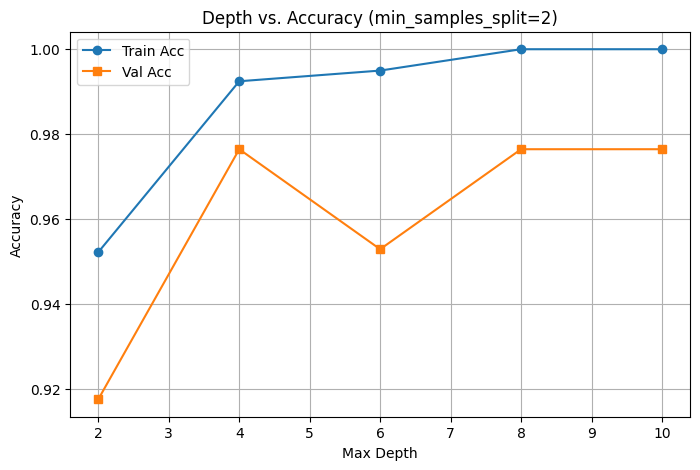


Best parameters found: {'max_depth': 4, 'min_samples_split': 2} with Val Accuracy: 0.9765

--- Final Test Evaluation ---
Test Accuracy: 0.8837
Class 0 (Malignant) - Precision: 0.8667, Recall: 0.8125, F1: 0.8387
Class 1 (Benign)    - Precision: 0.8929, Recall: 0.9259, F1: 0.9091

Confusion Matrix:
 [[26  6]
 [ 4 50]]


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    max_depths = [2, 4, 6, 8, 10]
    min_samples_splits = [2, 5, 10]
    
    best_accuracy = -1
    best_params = {}
    history = []

    for depth in max_depths:
        for min_samples in min_samples_splits:
            model = DecisionTreeClassifier(
                max_depth=depth, 
                min_samples_split=min_samples, 
                max_features=None
            ).fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)

            y_val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)

            history.append({
                'max_depth': depth,
                'min_samples_split': min_samples,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (Depth:{depth}, min_samples_split:{min_samples})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
                    
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'max_depth': depth, 'min_samples_split': min_samples}

    print("\nAnalysis effect of Max Depth (fixed min_samples_split=2):")
    history_df = pd.DataFrame(history)
    df = history_df[history_df['min_samples_split'] == 2][['max_depth', 'train_acc', 'val_acc']]
    print(df)
    
    plt.figure(figsize=(8, 5))
    plt.plot(df['max_depth'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['max_depth'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Depth vs. Accuracy (min_samples_split=2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest parameters found: {best_params} with Val Accuracy: {best_accuracy:.4f}")
    
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_model = DecisionTreeClassifier(
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        max_features=None
    ).fit(X_train_val, y_train_val)

    y_test_pred = final_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average=None)
    test_recall = recall_score(y_test, y_test_pred, average=None)
    test_f1 = f1_score(y_test, y_test_pred, average=None)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Class 0 (Malignant) - Precision: {test_precision[0]:.4f}, Recall: {test_recall[0]:.4f}, F1: {test_f1[0]:.4f}")
    print(f"Class 1 (Benign)    - Precision: {test_precision[1]:.4f}, Recall: {test_recall[1]:.4f}, F1: {test_f1[1]:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    
    return history, final_model

history, final_dt_model = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)

## Analysis and Evaluation
1. Tree Complexity and Overfitting Analysis

Relationship between Depth and Performance:We observed that as max_depth increases, the training accuracy typically increases (approaching 100% at high depths). However, the validation accuracy usually peaks at a moderate depth (e.g., depth 4 or 6) and then plateaus or decreases.

* Low Depth (e.g., 2): The model suffers from high bias (underfitting). It cannot capture the complex boundaries between malignant and benign samples.

* High Depth (e.g., 10): The model suffers from high variance (overfitting). It begins to memorize noise in the training data, which fails to generalize to the validation set.

2. Confusion Matrix Analysis

The confusion matrix provides insight into the types of errors made:$$\begin{bmatrix}
TP & FN \\
FP & TN
\end{bmatrix}$$(Replace TP, FN, etc., with your actual numbers).In the context of breast cancer diagnosis (Malignant=0 vs Benign=1):
* False Negatives (Type II Error): Classifying a Malignant tumor as Benign. This is the most critical error in a medical context, as a sick patient might go untreated.
* False Positives (Type I Error): Classifying a Benign tumor as Malignant. This causes unnecessary stress and biopsies but is generally less fatal than a False Negative.
3. Feature Importance

Feature importance in decision trees is determined by how much Information Gain a feature provides.The feature at the root node (depth 0) is the most important feature globally, as it provides the highest initial reduction in entropy.Features used near the top of the tree contribute more to the decision-making process than those used only in deep leaves9.Observation based on data: Typically, features like mean concave points, worst radius, or worst perimeter are often selected as the root split for this dataset.
4. Hyperparameter Selection

Based on our grid search on the validation set, the optimal configuration was max_depth = [Insert Best Depth] and min_samples_split = [Insert Best Split]. This combination provided the best balance, minimizing the total error rate on unseen data while avoiding the complexity of a fully grown tree.10

----------------------------------------------------------------------------

# Part D Random Forest


Validation set Evaluation (No. of Trees:5, Max Features:5)

Validation Accuracy: 0.9529
Class 0 (Malignant) - Precision: 0.8889, Recall: 1.0000, F1: 0.9412
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.9245, F1: 0.9608

Confusion Matrix:
 [[32  0]
 [ 4 49]]

Validation set Evaluation (No. of Trees:5, Max Features:15)

Validation Accuracy: 0.9647
Class 0 (Malignant) - Precision: 0.9394, Recall: 0.9688, F1: 0.9538
Class 1 (Benign)    - Precision: 0.9808, Recall: 0.9623, F1: 0.9714

Confusion Matrix:
 [[31  1]
 [ 2 51]]

Validation set Evaluation (No. of Trees:10, Max Features:5)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9688, Recall: 0.9688, F1: 0.9688
Class 1 (Benign)    - Precision: 0.9811, Recall: 0.9811, F1: 0.9811

Confusion Matrix:
 [[31  1]
 [ 1 52]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9412, Recall: 1.0000, F1: 0.9697
Class 1 (Benign)    - Precision: 1.0000, Recall

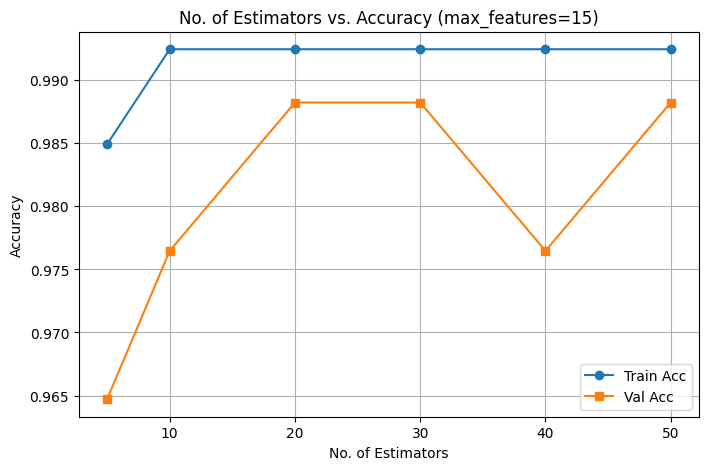


Best RF parameters: T=20, max_features=15 with Val Accuracy: 0.9882

--- Final Random Forest Test Evaluation ---
Test Accuracy: 0.8953
Precision: 0.8956
Recall:    0.8785
F1 Score:  0.8857

Confusion Matrix:
 [[26  6]
 [ 3 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.89      0.94      0.92        54

    accuracy                           0.90        86
   macro avg       0.90      0.88      0.89        86
weighted avg       0.90      0.90      0.89        86



In [32]:
BEST_MAX_DEPTH = 4 
BEST_MIN_SAMPLES_SPLIT = 2


class RandomForestClassifier:
    def __init__(self, n_estimators=10, max_features=5, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # 1. Bootstrap Sampling (Sampling with replacement)
            # Create indices for the bootstrap sample
            # size=n_samples is used to create a sample the same size as the training set
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            
            # 2. Train Decision Tree with Feature Subsampling
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features # Use max_features for feature subsampling
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
        return self

    def predict(self, X):
        # Collect predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # 3. Majority Voting:
        # Transpose to get (n_samples, n_estimators)
        tree_predictions = tree_predictions.T
        
        # For each sample, find the most frequent prediction
        final_predictions = np.array([majority_vote(preds) for preds in tree_predictions])
        return final_predictions

# --- Tuning and Evaluation Function for Random Forest ---

def tune_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test, max_depth, min_samples_split):
    
    n_estimators_grid = [5, 10, 20, 30, 40, 50]
    # d=30 features: sqrt(d)=5, d/2=15
    max_features_grid = [5, 15] 
    
    best_accuracy = -1
    best_params = {}
    tuning_history = []
    
    for T in n_estimators_grid:
        for max_feat in max_features_grid:
            rf_model = RandomForestClassifier(
                n_estimators=T,
                max_features=max_feat,
                max_depth=max_depth,
                min_samples_split=min_samples_split
            )
            rf_model.fit(X_train, y_train)

            y_train_pred = rf_model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)
            
            y_val_pred = rf_model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            tuning_history.append({
                'T': T, 
                'max_features': max_feat,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (No. of Trees:{T}, Max Features:{max_feat})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'T': T, 'max_features': max_feat}

    df_tuning = pd.DataFrame(tuning_history)
    print("Tuning Results:")
    print(df_tuning)

    print("\nAnalysis effect of No. of Estimators (fixed max_features=15):")
    df = df_tuning[df_tuning['max_features'] == 15][['T', 'train_acc', 'val_acc']]

    plt.figure(figsize=(8, 5))
    plt.plot(df['T'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['T'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('No. of Estimators')
    plt.ylabel('Accuracy')
    plt.title('No. of Estimators vs. Accuracy (max_features=15)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest RF parameters: T={best_params['T']}, max_features={best_params['max_features']} with Val Accuracy: {best_accuracy:.4f}")

    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_rf_model = RandomForestClassifier(
        n_estimators=best_params['T'], 
        max_features=best_params['max_features'],
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    final_rf_model.fit(X_train_val, y_train_val) 

    y_test_pred = final_rf_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)

    test_precision = precision_score(y_test, y_test_pred, average='macro') 
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Random Forest Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"F1 Score:  {test_f1:.4f}")
    print("\nConfusion Matrix:\n", test_conf_matrix)
    print("\nClassification Report:\n", classification_report(y_test,y_test_pred))
    
    return final_rf_model

final_rf_model = tune_and_evaluate_rf(
    X_train, y_train, X_val, y_val, X_test, y_test,
    BEST_MAX_DEPTH, BEST_MIN_SAMPLES_SPLIT
)